In [ ]:
#| echo: false
%load_ext autoreload
%autoreload 2

# Analyzing the trained models
> Access and interpret the models after fitting

## Data setup

In [ ]:
from mlforecast.utils import generate_daily_series

In [ ]:
series = generate_daily_series(10)
series.head()

,unique_id,ds,y
0,id_0,2000-01-01,0.322947
1,id_0,2000-01-02,1.218794
2,id_0,2000-01-03,2.445887
3,id_0,2000-01-04,3.481831
4,id_0,2000-01-05,4.191721


## Training

Suppose that you want to train a linear regression model using the day of the week and lag1 as features.

In [ ]:
from sklearn.linear_model import LinearRegression

from mlforecast import MLForecast

In [ ]:
fcst = MLForecast(
    freq='D',
    models={'lr': LinearRegression()},
    lags=[1],
    date_features=['dayofweek'],
)

In [ ]:
fcst.fit(series)

MLForecast(models=[lr], freq=<Day>, lag_features=['lag1'], date_features=['dayofweek'], num_threads=1)

What `MLForecast.fit` does is save the required data for the predict step and also train the models (in this case the linear regression). The trained models are available in the `MLForecast.models_` attribute, which is a dictionary where the keys are the model names and the values are the model themselves.

In [ ]:
fcst.models_

{'lr': LinearRegression()}

## Inspect parameters

We can access the linear regression coefficients in the following way:

In [ ]:
fcst.models_['lr'].intercept_, fcst.models_['lr'].coef_

(3.2476337167384415, array([ 0.19896416, -0.21441331]))

## SHAP

In [ ]:
#| shap
import shap

### Training set

If you need to generate the training data you can use `MLForecast.preprocess`.

In [ ]:
prep = fcst.preprocess(series)
prep.head()

,unique_id,ds,y,lag1,dayofweek
1,id_0,2000-01-02,1.218794,0.322947,6
2,id_0,2000-01-03,2.445887,1.218794,0
3,id_0,2000-01-04,3.481831,2.445887,1
4,id_0,2000-01-05,4.191721,3.481831,2
5,id_0,2000-01-06,5.395863,4.191721,3


We extract the X, which involves dropping the info columns (id + times) and the target

In [ ]:
X = prep.drop(columns=['unique_id', 'ds', 'y'])
X.head()

,lag1,dayofweek
1,0.322947,6
2,1.218794,0
3,2.445887,1
4,3.481831,2
5,4.191721,3


We can now compute the shap values

In [ ]:
#| shap
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(fcst.models_['lr'].predict, X100)
shap_values = explainer(X)

And visualize them

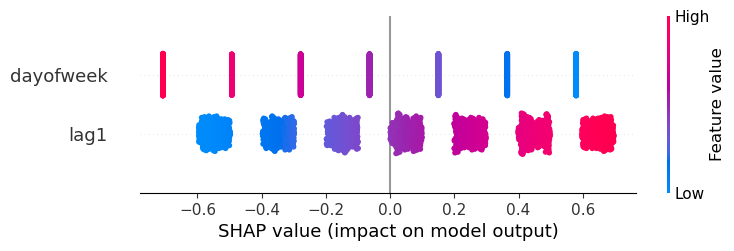

In [ ]:
#| shap
shap.plots.beeswarm(shap_values)

### Predictions

Sometimes you want to determine why the model gave a specific prediction. In order to do this you need the input features, which aren't returned by default, but you can retrieve them using a callback.

In [ ]:
from mlforecast.callbacks import SaveFeatures

In [ ]:
save_feats = SaveFeatures()
preds = fcst.predict(1, before_predict_callback=save_feats)
preds.head()

,unique_id,ds,lr
0,id_0,2000-08-10,3.468643
1,id_1,2000-04-07,3.016877
2,id_2,2000-06-16,2.815249
3,id_3,2000-08-30,4.048894
4,id_4,2001-01-08,3.524532


You can now retrieve the features by using `SaveFeatures.get_features`

In [ ]:
features = save_feats.get_features()
features.head()

,lag1,dayofweek
0,4.343744,3
1,3.150799,4
2,2.137412,4
3,6.182456,2
4,1.391698,0


And use those features to compute the shap values.

In [ ]:
#| shap
shap_values_predictions = explainer(features)

We can now analyze what influenced the prediction for `'id_4'`.

In [ ]:
round(preds.loc[4, 'lr'], 3)

3.525

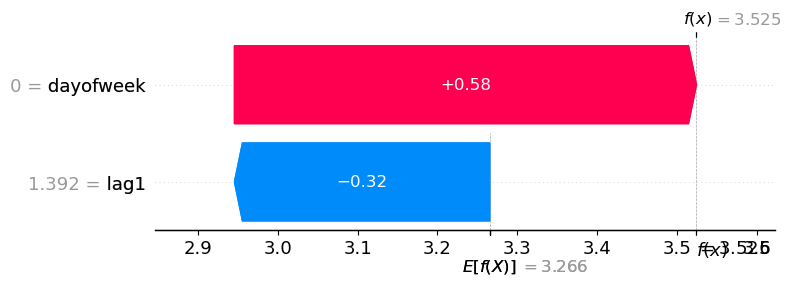

In [ ]:
#| shap
shap.plots.waterfall(shap_values_predictions[4])